## TD;DR

After practicint with elastic material modelling, we'll continue to nonlinear material modelling: viscoplasticity. We'll explore Norton and Birgin viscoplastic potential equations, von Mises yield function, automatic derivation using ForwardDiff. 

Note! Equations are written in tensor notation, but the implementated code is in matrix notation!

## Recap to linear material modelling

Here's a small example from elastic material modelling with matrix notation.

\begin{equation}
\sigma = C : \epsilon
\end{equation}

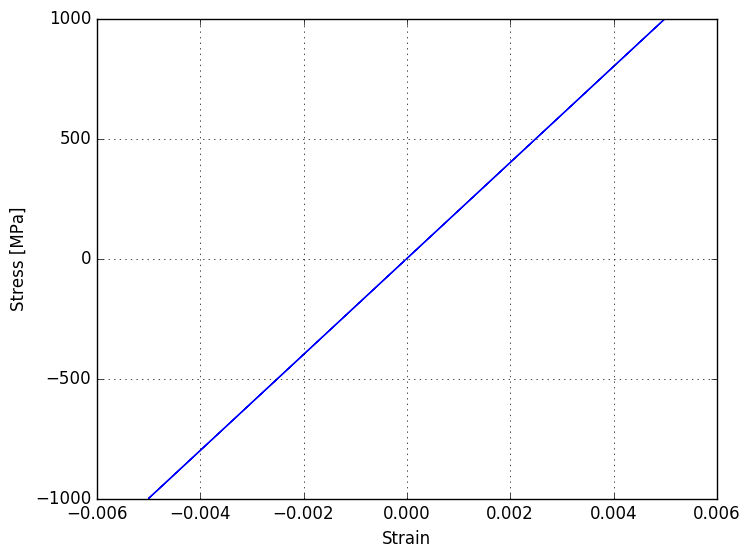

PyObject <matplotlib.text.Text object at 0x7f511f902ad0>

In [1]:
using PyPlot
using ForwardDiff

num = 100                  # Number of steps
E = 200000.0             # Young's modulus [GPa]
ν = 0.3                  # Poisson's ratio

L = 1000.0               # Initial length [mm]
ΔL = linspace(0, 5, num)   # Change of length [mm]

ϵ_ = collect(ΔL / L)
ϵ_total = vec([ϵ_; reverse(ϵ_[2:end-1]); -ϵ_; reverse(-ϵ_[2:end-1])])
#ϵ_total = ϵ_
I = eye(3)
total_num = length(ϵ_total)

σ = zeros(total_num, 6)

C = E / ((1 + ν)*(1 - 2*ν)) * [
    1-ν   ν   ν         0         0         0
      ν 1-ν   ν         0         0         0
      ν   ν 1-ν         0         0         0
      0   0   0 (1-2*ν)/2         0         0
      0   0   0         0 (1-2*ν)/2         0
      0   0   0         0         0 (1-2*ν)/2]

for i=1:(total_num)
    ϵ = zeros(6)
    ϵ[1] = ϵ_total[i]
    ϵ[2] = -ϵ_total[i] * ν
    ϵ[3] = -ϵ_total[i] * ν

    # The most general form of Hooke's law for isotropic materials
    σ[i, :] = C * ϵ
end

σ_11 = vec(σ[:, 1])
plot(ϵ_total, σ_11)
grid()
xlabel("Strain")
ylabel("Stress [MPa]")

## Nonlinear material

### Decomposition of strain
Strain increment de is decomposed into the elastic part de e and the plastic part de p using kinematics. Additive decomposition is used for small strains and multiplicative decomposition for large strains. In elasticplastic materials the strain increment is decomposed into an elastic and a plastic
part: [ref](http://eu.wiley.com/WileyCDA/WileyTitle/productCd-1118632702.html)


\begin{equation}
d\epsilon = d\epsilon^e + d\epsilon^p
\end{equation}

Dividing both sides with the differential time increment $dt$ produces the rate form:

\begin{equation}
\dot\epsilon = \dot\epsilon^e + \dot\epsilon^p
\end{equation}

Diving Equation 1 with time increment and substituting elastic strain rate produces relation for linear region:

\begin{equation}
\dot\sigma = C : \dot\epsilon^e = C : (\dot\epsilon - \dot\epsilon^p)
\end{equation}

In the non-linear regime, the stress-strain relation is defined as:

\begin{equation}
\dot\sigma = C : \dot\epsilon^e = C^{tan} : \dot\epsilon
\end{equation}
Formulation of viscoplastic constitutive equations

### Yield function

https://en.wikipedia.org/wiki/Von_Mises_yield_criterion

Yield function defines the transition between elastic and plastic zones. Common yield function is von Mises yield function, which is defined as: 

\begin{equation}
f(\sigma) = \sigma_{eq}(\sigma) - \sigma_y
\end{equation}

\begin{equation}
\sigma_{eq}(\sigma) = \sqrt{3J_2(\sigma)}
\end{equation}

\begin{equation}
J_2(\sigma) = \frac{1}{2}s:s
\end{equation}

\begin{equation}
s = \sigma - \frac{1}{3}\rm{tr}(\sigma)I
\end{equation}



In [2]:
function deviatoric_stress(σ)
    σ_tensor = [σ[1] σ[4] σ[6];
                σ[4] σ[2] σ[5];
                σ[6] σ[5] σ[3]]
    σ_dev = σ_tensor - 1/3 * trace(σ_tensor) * eye(3)
    return [σ_dev[1, 1], σ_dev[2, 2], σ_dev[3, 3], σ_dev[1, 2], σ_dev[2, 3], σ_dev[1, 3]] 
end

function J_2_stress(σ)
    s = deviatoric_stress(σ)
    s_vec = vec([s; s[4]; s[5]; s[6]])  # Adding missing shear elements for double dot product
    return 1/2 * dot(s_vec, s_vec)      # equivalent to sqrt(1/2 * s : s), in tensor notation 
end

function equivalent_stress(σ)
    J_2 = J_2_stress(σ)
    return sqrt(3 * J_2)
end

function von_mises_yield(σ, σ_y)
    return equivalent_stress(σ) - σ_y
end

von_mises_yield (generic function with 1 method)

In [3]:
using IJulia.display

HTML("""
<div>
<img src="von_mises_2d.png" alt="Mountain View" style="width:533px;height:400px;" align="left">
<video width="440" height="440" controls align="rigth">
  <source src="./vonmises_yield_surface.mp4" type="video/mp4">
</video>
</div>
""")

HTML{ASCIIString}("<div>\n<img src=\"von_mises_2d.png\" alt=\"Mountain View\" style=\"width:533px;height:400px;\" align=\"left\">\n<video width=\"440\" height=\"440\" controls align=\"rigth\">\n  <source src=\"./vonmises_yield_surface.mp4\" type=\"video/mp4\">\n</video>\n</div>\n")

[![Everything Is AWESOME](http://img.youtube.com/vi/StTqXEQ2l-Y/0.jpg)](https://www.youtube.com/watch?v=StTqXEQ2l-Y "Everything Is AWESOME")

todo


### Viscoplastic potential

In [4]:
# Norton rule and von Mises criterion


function norton_plastic_potential(σ, K, n, f)
    f_ = f(σ)
    return K/(n+1) * (f_ / K) ^ (n + 1)
end

norton_plastic_potential (generic function with 1 method)

### Flow rule

In [13]:
function analytical_dΦdσ(σ, K, n, f)
    f_ = f(σ)
    σ_v = equivalent_stress(σ)
    σ_dev_vec = deviatoric_stress(σ)
    return (f_ / K) ^ n * 3 / 2 * σ_dev_vec / σ_v
end

analytical_dΦdσ (generic function with 1 method)

### Summary of needed functions

http://mms2.ensmp.fr/msi_paris/plasticity/transparents/Expo2.pdf

http://mms2.ensmp.fr/msi_paris/archives-transparents/JLC-Plasticity.pdf

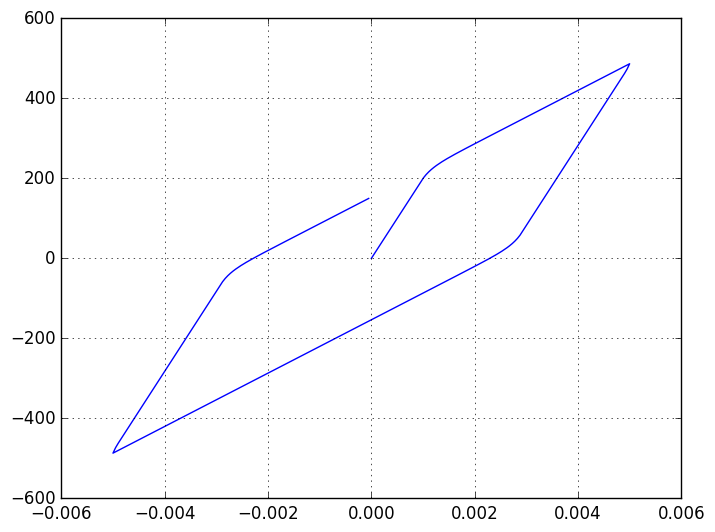

In [14]:
σ_hist = zeros(total_num, 6)

σ_y = 200.0
ϵ_last = zeros(6)
σ = zeros(6)
Δt = 0.1
n = 0.92
K = 180.0e3
ϵ = zeros(6)
ϵ_hist = zeros(total_num, 6)

f = x->von_mises_yield(x, 200.)

for i=2:total_num
    ϵ = zeros(6)
    ϵ[1] = ϵ_total[i]
    ϵ[2] = -ϵ_total[i] * ν
    ϵ[3] = -ϵ_total[i] * ν
    
    dϵdt = (ϵ - ϵ_last) / Δt
    dσdt = C * dϵdt
    σ_tria = σ + dσdt * Δt
    yield_ = f(σ_tria)
    if yield_ > 0
        dϵ_vp = analytical_dΦdσ(σ_tria, K, n, f)
        σ += C * (dϵdt - dϵ_vp) * Δt
    else
        σ[:] = σ_tria
    end
    σ_hist[i, :, :] = σ
    ϵ_last[:] = ϵ
    ϵ_hist[i, :] = ϵ
end
plot(ϵ_hist[:, 1], σ_hist[:, 1])
grid()

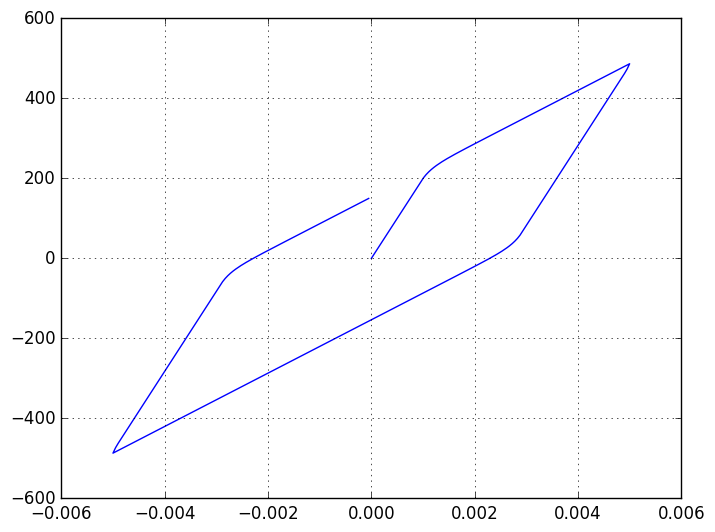

In [15]:
σ_hist = zeros(total_num, 6)

σ_y = 200.0
ϵ_last = zeros(6)
σ = zeros(6)
Δt = 0.1
n = 0.92
K = 180.0e3
ϵ = zeros(6)
ϵ_hist = zeros(total_num, 6)


f = x->von_mises_yield(x, σ_y)

for i=2:total_num
    ϵ = zeros(6)
    ϵ[1] = ϵ_total[i]
    ϵ[2] = -ϵ_total[i] * ν
    ϵ[3] = -ϵ_total[i] * ν
    
    dϵdt = (ϵ - ϵ_last) / Δt
    dσdt = C * dϵdt
    σ_tria = σ + dσdt * Δt
    yield_ = f(σ_tria)
    if yield_ > 0
        wrap = x-> norton_plastic_potential(x, K, n, f)
        dϵ_vp = ForwardDiff.gradient(wrap, σ_tria)
        σ += C * (dϵdt - dϵ_vp) * Δt
    else
        σ[:] = σ_tria
    end
    σ_hist[i, :, :] = σ
    ϵ_last[:] = ϵ
    ϵ_hist[i, :] = ϵ
end
plot(ϵ_hist[:, 1], σ_hist[:, 1])
grid()

In [16]:
function bingham_plastic_potential(σ, η, f)
    return 0.5 * (f(σ) / η) ^2
end

bingham_plastic_potential (generic function with 1 method)

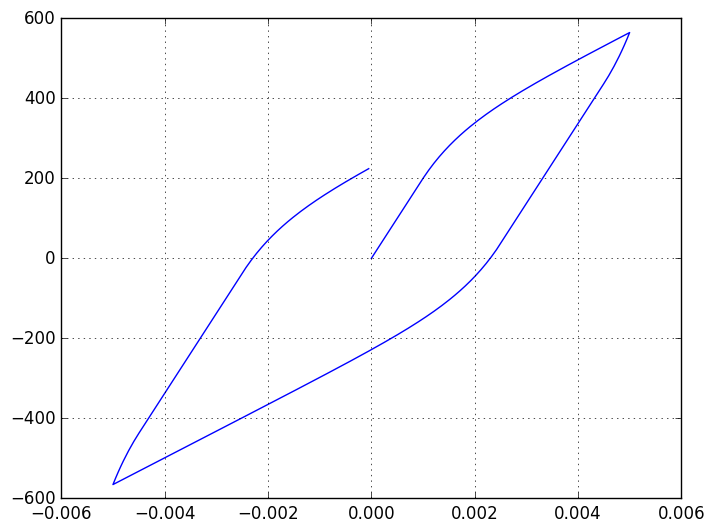

In [17]:
σ_hist = zeros(total_num, 6)

σ_y = 200.0
ϵ_last = zeros(6)
σ = zeros(6)
Δt = 0.01
ϵ = zeros(6)
ϵ_hist = zeros(total_num, 6)
η=190.

f = x->von_mises_yield(x, σ_y)

for i=2:total_num
    ϵ = zeros(6)
    ϵ[1] = ϵ_total[i]
    ϵ[2] = -ϵ_total[i] * ν
    ϵ[3] = -ϵ_total[i] * ν
    
    dϵdt = (ϵ - ϵ_last) / Δt
    dσdt = C * dϵdt
    σ_tria = σ + dσdt * Δt
    yield_ = f(σ_tria)
    if yield_ > 0
        wrap = x->bingham_plastic_potential(x, η, f)
        dϵ_vp = ForwardDiff.gradient(wrap, σ_tria)
        σ += C * (dϵdt - dϵ_vp) * Δt
    else
        σ[:] = σ_tria
    end
    σ_hist[i, :, :] = σ
    ϵ_last[:] = ϵ
    ϵ_hist[i, :] = ϵ
end
plot(ϵ_hist[:, 1], σ_hist[:, 1])
grid()